In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import os 
from torchvision.io import read_image
import argparse
import os
import random
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.datasets import ImageFolder
from torch.optim import Adam
import glob
import json
# from torchinfo import summary

In [10]:
# Root directory for dataset
root_dir = r'/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/Splitted data by era - GAN project/test_iron'
res_dir = r'results/gan_results'

# Number of workers for dataloader. (4 * nr_gpus)
workers = (4 * 1)

# Spatial size of training images. All images will be resized to this size, using a transformer.
image_size = 64

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# RGB
n_channels = 3 

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device: ", device)

Device:  cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73333335..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input da

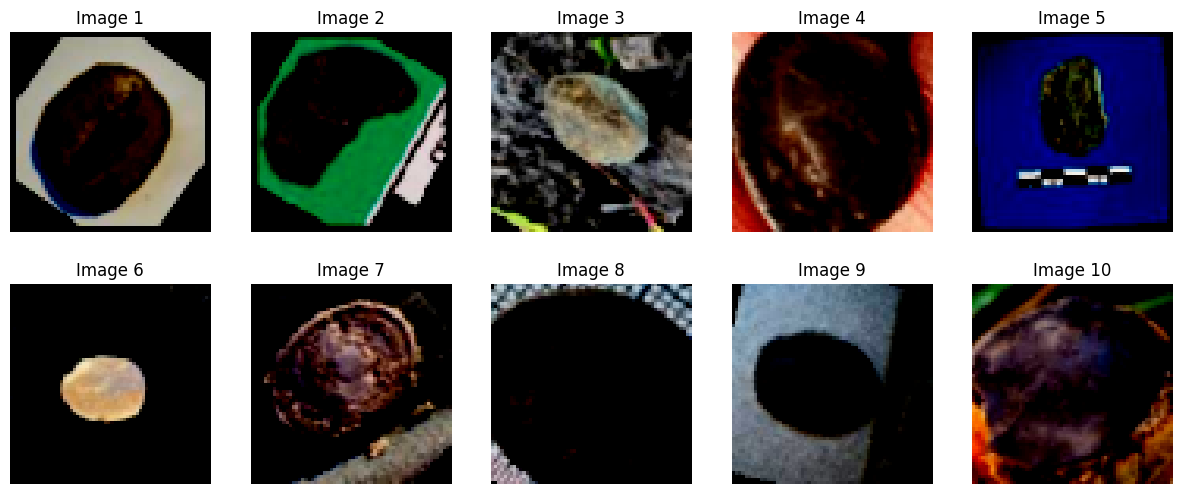

In [11]:
# TODO: Add image interpolation for sharper images 

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to 64x64 + interpolation
    transforms.ToTensor(),           
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [-1,1] for each channel -> input[channel]=(input[channel]−mean[channel])/std[channel]
])

dataset = ImageFolder(root = root_dir, transform = transform)

def show_images(images):
    fig, axes = plt.subplots(2, 5, figsize = (15, 6))  # Create a grid of subplots (2 rows, 5 columns)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))  # Convert from tensor format to numpy array and rearrange dimensions
        ax.axis('off')  
        ax.set_title(f'Image {i + 1}')   
    plt.show()

images = [dataset[i][0] for i in range(10)]

# Display the image
show_images(images)

In [12]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) # Mean 0, STD 0.2
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class D(nn.Module):
    def __init__(
            self, 
            ndf, 
            ngpu
        ):
        super(D, self).__init__()
        self.ngpu = ngpu
        ndf = ndf 
    
        self.main = nn.Sequential(
            # Input is (n_channels) x 128 x 128
            nn.Conv2d(n_channels, ndf, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            # State size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace = True),
            # State size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace = True),
            # State size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace = True),
            # State size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x) # Output size = 1x1 
        return x 



class G(nn.Module):
    def __init__(
        self,
        nz, 
        ngf,
        ngpu
    ): 
        super(G, self).__init__()
        self.ngpu = ngpu

        latent_size = nz
        ngf = ngf
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(latent_size, ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace = True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace = True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace = True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace = True),
            # state size. ``(nc) x 64 x 64``
            # Adding one more layer to upscale from 64x64 to 128x128
            nn.ConvTranspose2d(ngf, n_channels, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
            # state size. ``(nc) x 128 x 128``
        )        

    def forward(self, x):
        x = self.main(x) # Output size = 64x64 
        return x 


# Generate summaries:
# discriminator = D(hyperparams = {'ndf': 64})  
# generator = G(hyperparams = {'nz': 100, 'ngf': 64})  

# discriminator_summary = summary(discriminator, input_size = (25, 3, 128, 128))
# generator_summary = summary(generator, input_size = (25, 100, 1, 1))

# Print summaries
# print("Discriminator Summary:")
# print(discriminator_summary)

# print("\nGenerator Summary:")
# print(generator_summary)

In [13]:
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

def save_checkpoint(g_model, d_model, optimizer_g, optimizer_d):
    checkpoint_path = os.path.join(checkpoint_dir, f"gan_checkpoint.pt")

    # Check if data parallel is used, then save the state accordingly
    g_model_state_dict = g_model.module.state_dict() if isinstance(g_model, torch.nn.DataParallel) else g_model.state_dict()
    d_model_state_dict = d_model.module.state_dict() if isinstance(d_model, torch.nn.DataParallel) else d_model.state_dict()

    torch.save({
        'generator_state_dict': g_model_state_dict,
        'discriminator_state_dict': d_model_state_dict,
        'optimizer_g_state_dict': optimizer_g.state_dict(),
        'optimizer_d_state_dict': optimizer_d.state_dict()
    }, checkpoint_path)

def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    # Load state_dict into the original model if using DataParallel
    if isinstance(g_model, torch.nn.DataParallel):
        g_model.module.load_state_dict(checkpoint['generator_state_dict'])
    else:
        g_model.load_state_dict(checkpoint['generator_state_dict'])
    
    if isinstance(d_model, torch.nn.DataParallel):
        d_model.module.load_state_dict(checkpoint['discriminator_state_dict'])
    else:
        d_model.load_state_dict(checkpoint['discriminator_state_dict'])

    optimizer_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d_state_dict'])

    return g_model, d_model, optimizer_g, optimizer_d


def find_latest_checkpoint():
    checkpoints = glob.glob(os.path.join(checkpoint_dir, "gan_checkpoint.pt"))
    if checkpoints: 
        # Use the OS metadata to recognize the latest file changed/added
        latest_checkpoint = max(checkpoints, key = os.path.getctime)
        return latest_checkpoint
    else: 
        return None


In [18]:
real_label = 1 
fake_label = 0 
n_epochs = 1000 
start_epoch = 0
latest_checkpoint = None 
g_state_dict = None 
d_state_dict = None 
optimizer_g_state_dict = None
optimizer_d_state_dict = None

img_list = [] 

# Hyperparams 
lr = 0.0005 
nz = 100 
ngf = 32
ndf = 70 
batch_size = 128 

# Init models 
d_model = D(ndf = ndf, ngpu = ngpu).to(device)
g_model = G(ngf = ngf, ngpu = ngpu, nz = nz).to(device)

# Optimizers 
optimizer_d = Adam(d_model.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_g = Adam(g_model.parameters(), lr = lr, betas = (0.5, 0.999))

# Loss function 
criterion = nn.BCELoss()

# Look for checkpoint 
checkpoint = find_latest_checkpoint()
if checkpoint: 
    print("Checkpoint was found! Setting model and optimizer states")
    g_with_states, d_with_states, optimizer_g_with_states, optimizer_d_with_states = load_checkpoint(checkpoint)
    g_model = g_with_states
    d_model = d_with_states
    optimizer_g = optimizer_g_with_states
    optimizer_d = optimizer_d_with_states
else: 
    print("Applying weights init")
    g_model.apply(weights_init)
    d_model.apply(weights_init)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    g_model = nn.DataParallel(g_model, list(range(ngpu)))
if (device.type == 'cuda') and (ngpu > 1):
    d_model = nn.DataParallel(d_model, list(range(ngpu)))

losses_file_path = os.path.join(res_dir, 'losses.txt')
# Check if the losses file already exists    
if not os.path.exists(losses_file_path):
    with open(losses_file_path, 'w') as f:
        f.write("")
else: 
    with open(losses_file_path, 'r') as f:
        lines = f.readlines() 
        # Update current epoch
        if lines:
            last_line = lines[-1]
            parts = last_line.split(' - ')
            # Set start epoch if found 
            start_epoch = int(parts[0])

# Fresh dataloader
data_loader = DataLoader(
    dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = workers # Parallel workers
)

# Used for showing the progression of G
# Number of fake images made is 64
fixed_noise = torch.randn(64, nz, 1, 1, device = device) 

# Training 
for epoch in range(start_epoch, n_epochs):
    D_losses = []
    G_losses = []
    img_list = []
    avg_loss_G = []
    avg_loss_D = [] 

    # Epoch folder
    epoch_dir = os.path.join(res_dir, f"epoch_{epoch}")
    if not os.path.exists(epoch_dir):
        os.makedirs(epoch_dir)
    
    # Save model states every 5 epoch
    if epoch % 5 == 0: 
        save_checkpoint(
            g_model = g_model, 
            d_model = d_model, 
            optimizer_g = optimizer_g, 
            optimizer_d = optimizer_d
        )
    
    for i, data in enumerate(data_loader, 0):
        # Train discriminator with real images:
        d_model.zero_grad() 
        real_device = data[0].to(device)
        b_size = real_device.size(0)
        # Fill the batch with real_labels i.e. 1
        label = torch.full((b_size,), real_label, dtype = torch.float, device = device) 
        # Forward 
        output = d_model(real_device).view(-1)
    
        errD_real = criterion(output, label)
        errD_real.backward()
        # Calc mean loss over whole batch
        D_x = output.mean().item()
        
        latent = torch.randn(b_size, nz, 1, 1, device = device) 
        fake = g_model(latent) 
        label.fill_(fake_label) 
        output = d_model(fake.detach()).view(-1) 
        errD_fake = criterion(output, label)
        errD_fake.backward() 
        D_G_z1 = output.mean().item()
        # Compute the total error for the discriminator over real and fake runs 
        errD = errD_real + errD_fake 
        optimizer_d.step()
    
        # Save a batch of generated images at the end of each epoch - Quality check
        if epoch == n_epochs - 1:
            with torch.no_grad():
                fake_images = g_model(latent).detach().cpu()  
            # Save each image in the batch individually
            for j, img in enumerate(fake_images):
                img_filename = os.path.join(epoch_dir, f'generated_image_{epoch}_{i}_{j}.png')
                vutils.save_image(img, img_filename, normalize = True)
    
        # Train the generator 
        g_model.zero_grad() 
        label.fill_(real_label) # fake labels are real for generator cost
        output = d_model(fake).view(-1) # Since we just updated D, perform another forward pass of all-fake batch through D (d_model)
        errG = criterion(output, label) # Calculate G's loss based on this output
        errG.backward()
        D_G_z2 = output.mean().item() # Same as (D_G_z1 -> D(G(z1))) - The output loss on fake images made by the generator. Training
        optimizer_g.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
        if (i == len(data_loader) - 1):
            with torch.no_grad():
                # Number of fake images generated depends on the fixed noise vector
                fake = g_model(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding = 2, normalize = True))
    
    # Calculate mean loss for the epoch
    avg_loss_G_epoch = np.mean(G_losses)
    avg_loss_D_epoch = np.mean(D_losses)
    
    # Save losses to a file
    with open(os.path.join(res_dir, 'losses.txt'), 'a') as f:
        f.write(f"{epoch} - {avg_loss_G_epoch} : {avg_loss_D_epoch}\n")
    
    for i, img_grid in enumerate(img_list):
        filename = os.path.join(epoch_dir, f'generated_images_epoch_{i}.png')
        vutils.save_image(img_grid, filename) 
    
# Plot and save the losses graph
epochs = []
generator_losses = []
discriminator_losses = []
with open(os.path.join(res_dir, 'losses.txt'), 'r') as file:
    lines = file.readlines()
    for line in lines: 
        parts = line.strip().split(' - ')
        epoch = int(parts[0])
        losses = parts[1].split(' : ')
        generator_loss = float(losses[0])
        discriminator_loss = float(losses[1])

        epochs.append(epoch)
        generator_losses.append(generator_loss)
        discriminator_losses.append(discriminator_loss)
    
# Plot and save the losses graph
plt.figure(figsize = (10, 5))
plt.plot(epochs, generator_losses, label = 'Generator Loss')
plt.plot(epochs, discriminator_losses, label = 'Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses across Epochs')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(res_dir, 'epoch_losses_graph.png'))
plt.show()

Checkpoint was found! Setting model and optimizer states



KeyboardInterrupt

